In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [104]:
###Define Inputs
#!!input document must be delineated with two collumns of (x,y) points!!
fouriersignal = np.loadtxt("26vcal.txt",float)
hires = 10 #high resolution at low frequencies, set to at least 2;
          #gives a factor of #hires finer frequency sampling, but with a factor of #hires smaller frequency window
hiresoff = 0 #start at frequency hiresoff/T/hires

time = fouriersignal[:,0]
signal = fouriersignal[:,1]
T = time[-1] - time[0] #total integration period
N = len(time) #number of points
FFTs = np.zeros([N//2,3]) #Fourier frequencies, amplitudes, and phases
FFTshr = np.zeros([N//2,3]) #high res

# The DFT is always symmetric about its midpoint.
# Frequencies above the midpoint are below the Nyquist criterion and does not represent real frequencies.
for f in range(1,N//2): #iterate over frequencies
    A = 0
    Ahr = 0
    for d in range(N): #iterate over data points
        A += signal[d] * np.exp(-1j*2*np.pi*d*f/N) #integrate at frequencies f/N, A = a +ib for the fourier expansion f(t) = a*cos(wt)+bsin(wt)
        Ahr += signal[d] * np.exp(-1j*2*np.pi*d*(f+hiresoff)/N/hires)
    
    FFTs[f,0] = f/T #frequency
    FFTs[f,1] = la.norm(A)/N*2 #amplitude, factor of 2 to account for symmetry of DFT
    FFTs[f,2] = np.arctan2(np.imag(A),np.real(A)) #phase
    
    FFTshr[f,0] = (f+hiresoff)/T/hires #hires frequency
    FFTshr[f,1] = la.norm(Ahr)/N/hires*2 #hires amplitude
    FFTshr[f,2] = np.arctan2(np.imag(Ahr),np.real(Ahr)) #hires phase

#Inverse Fourier transform
invFT = np.zeros(N,complex)
invFThr = np.zeros(N,complex)

for d in range(N): #iterate over data points
    for f in range(N//2): #iterate over frequencies
        invFT[d] += FFTs[f,1] * np.exp(2j*np.pi*d/N*f+1j*FFTs[f,2])
        invFThr[d] += FFTshr[f,1] * np.exp(2j*np.pi*d/N*(f+hiresoff)/hires+1j*FFTshr[f,2])
#take real part and add the DC offset back
ReinvFT = np.real(invFT) + signal[0] - np.real(invFT[0])
ReinvFThr = np.real(invFThr) + signal[0] - np.real(invFThr[0])

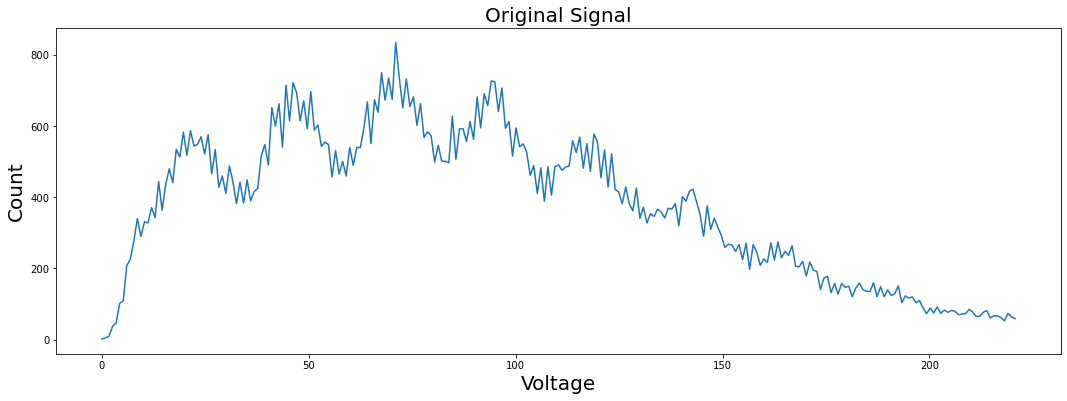

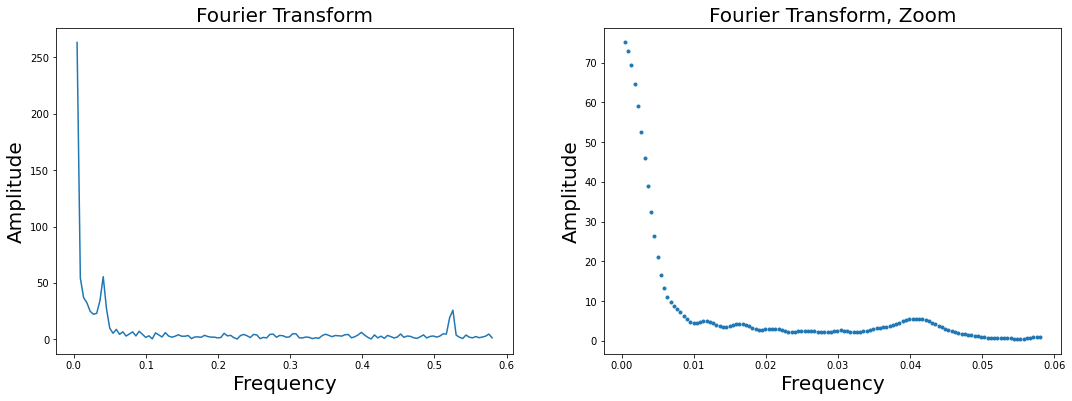

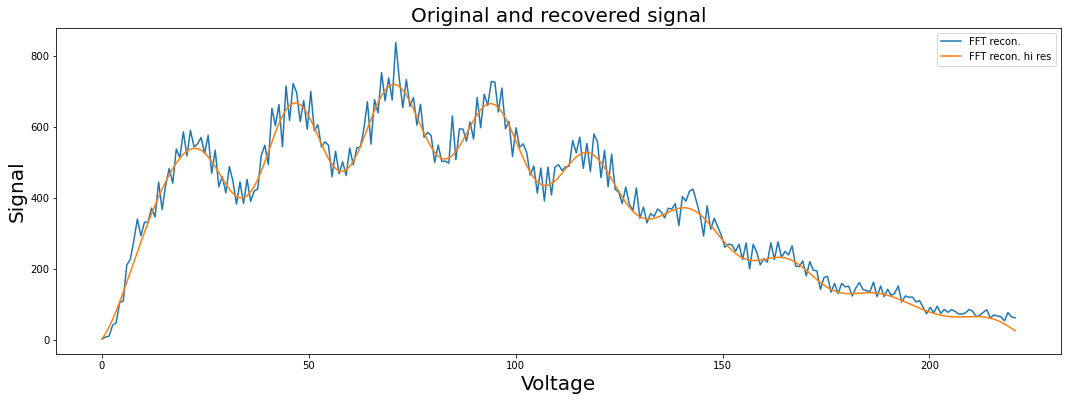

In [105]:
#make plots
plt.rcParams["figure.figsize"] = (18,6)
plt.plot(time,signal)
plt.title("Original Signal", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Count", size=20)
plt.show()

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(FFTs[1:,0],FFTs[1:,1],"-")
ax[0].set_title("Fourier Transform", size=20)
ax[0].set_xlabel("Frequency", size=20)
ax[0].set_ylabel("Amplitude", size=20)

ax[1].plot(FFTshr[1:,0],FFTshr[1:,1],".")
ax[1].set_title("Fourier Transform, Zoom", size=20)
ax[1].set_xlabel("Frequency", size=20)
ax[1].set_ylabel("Amplitude", size=20)
plt.show()

plt.plot(time,ReinvFT,label="FFT recon.")
plt.plot(time,ReinvFThr,label="FFT recon. hi res")
plt.legend()
plt.title("Original and recovered signal", size=20)
plt.xlabel("Voltage", size=20)
plt.ylabel("Signal", size=20)
plt.show()

## There are two main, expected effects present: The highest frequency components have been removed, smoothing out the sharp peaks, and the exact maxima in the frequency spectrum are more clear.

## The simplest modification to make is a highpass or highpass filter. As the lowpass cutoff decreases, the graph becomes more smooth, but with a similar amplitude. Conversely, the highpass filter preserves many of the detailed features, but drastically reduces the RMS.

In [99]:
#peak finder
max(FFTshr[1:N//2,1])
max_y = max(FFTshr[N//4:N//2,1])  # Find the maximum y value
max_x = FFTshr[np.where(FFTshr==max_y)[0][0],0]  # Find the x value corresponding to the maximum y value
print("maxima found in the given range at x=" + str(max_x)+", y="+ str(max_y))
print(1/max_x)
print(1/(max_x+0.00011))

maxima found in the given range at x=0.04123412372955852, y=1.3763714005789203
24.251758241758242
24.187234116781173


In [97]:
24.252
23.988
23.477
24.521

FFTshr

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.03409745,  0.65714429, -3.03712748],
       [ 0.03421073,  0.6715835 , -3.05154454],
       [ 0.03432401,  0.68584445, -3.06783605],
       [ 0.03443729,  0.69980645, -3.08579362],
       [ 0.03455057,  0.71336863, -3.10520837],
       [ 0.03466385,  0.72645025, -3.12587539],
       [ 0.03477713,  0.73899063,  3.13558824],
       [ 0.03489041,  0.75094891,  3.11299981],
       [ 0.03500369,  0.7623036 ,  3.08972098],
       [ 0.03511697,  0.77305206,  3.06591512],
       [ 0.03523025,  0.78320965,  3.04173148],
       [ 0.03534353,  0.79280895,  3.01730407],
       [ 0.03545682,  0.80189859,  2.99275067],
       [ 0.0355701 ,  0.81054207,  2.9681718 ],
       [ 0.03568338,  0.81881628,  2.94364971],
       [ 0.03579666,  0.82680977,  2.91924735],
       [ 0.03590994,  0.83462093,  2.8950074 ],
       [ 0.03602322,  0.84235574,  2.87095152],
       [ 0.0361365 ,  0.85012544,  2.84707977],
       [ 0.03624978,  0.85804398,  2.823